<a href="https://colab.research.google.com/github/Zokoban/pyOCRTEN/blob/main/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download all data on the drive 

In [5]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

## Load all the required packages

In [6]:
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Load word.txt file

In [7]:
word_txt=pd.read_csv("data/words.txt",sep=' ',names=["word_id","segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","transcription_1","transcription_2","transcription_3"] ,quoting=csv.QUOTE_NONE,skiprows=18,on_bad_lines="warn")

def f(x):
    if x == "nan":
        return ""
    else:
        return x
word_txt["transcription"]=word_txt.transcription_1.astype("str")+word_txt.transcription_2.astype("str").apply(f)+word_txt.transcription_3.astype("str").apply(f)
word_txt=word_txt.drop(columns=["transcription_1","transcription_2","transcription_3"])

def f(x):
    return len(x)

word_txt["number_components"]=word_txt.transcription.apply(f)

print("word_txt Length: ",len(word_txt))
word_txt.head()

word_txt Length:  115320


,word_id,segmentation_result,gray_level,x,y,pxw,pxh,grammatical_tag,transcription,number_components
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,3


### Choice of the fraction of the dataset.
### Removal of the transcription error.
### Removal of the unwanted columns.

In [8]:
list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]
fraction = 0.5
df = word_txt[word_txt.segmentation_result == "ok"]\
    .drop(columns=list_columns_to_remove)\
    .sample(frac=fraction)
  
print("df Length: ",len(df))
df.head()

df Length:  48228


,word_id,transcription
36981,d06-050-01-01,the
105340,n06-163-06-09,he
106530,p02-027-02-07,.
6799,a02-116-02-00,Committee
35127,d04-096-05-04,in


## Separation to Train dataset and Test dataset

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)

y_train = df_train.transcription
y_test = df_test.transcription

In [10]:
df_train

,word_id,transcription
69433,g07-003a-03-03,'
59556,g06-018i-03-06,this
76074,h07-030-02-03,part
47510,f04-007-02-00,There
31638,c06-080-05-06,of
...,...,...
57074,g05-098-03-07,to
108730,p03-072-05-13,He
57173,g06-011a-05-02,is
52468,g01-008-05-04,St


## Loading the images (features)

In [11]:
def img_word(word):
    path="data/words/"+word.split("-")[0]+"/"+word.split("-")[0]+"-"+word.split("-")[1]+"/"+word+".png"
    word_img=cv2.imread(path)

    return word_img

X_train= df_train.word_id.apply(img_word)
X_test = df_test.word_id.apply(img_word)

#Removal of the index in which the image have not been loaded (error or image not in the dataset)  
y_train=y_train.drop(index=y_train[X_train.isna()].index)
y_test=y_test.drop(index=y_test[X_test.isna()].index)
X_test=X_test[X_test.isna()==False]
X_train=X_train[X_train.isna()==False]

### Display of several images

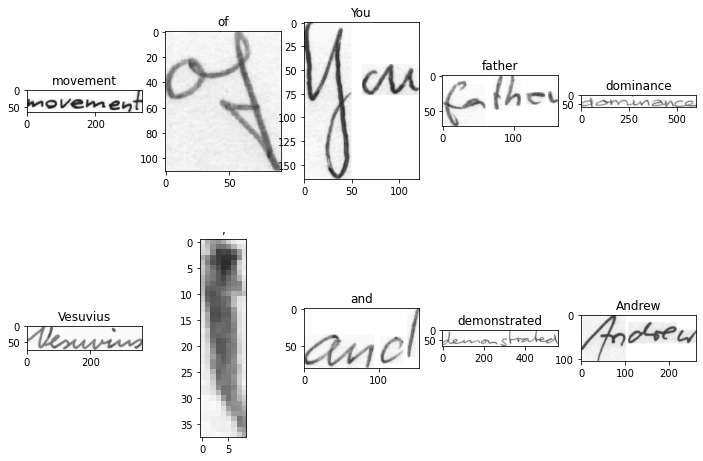

In [12]:
j=1
plt.figure(figsize=(12,8))
for rand in np.random.choice(np.arange(0, len(X_train)), size=10):
    plt.subplot(2,5,j)
    word = y_train.iloc[rand]
    plt.imshow(X_train.iloc[rand])
    plt.title(word);

    j=j+1

### Resizing homogenization and no distortion

In [13]:
def resize_no_distortion(img,resize):
  reshape_size=resize
  sw, sh=reshape_size

  reshape_ratio=sh/sw

  #Recovery of the height and width of the image
  h, w = img.shape[:2]
  
  ratio_image=h/w

  #Recovery of the number of canals
  c = img.shape[2] if len(img.shape)>2 else 1
  

  #dif = max(h,w)
  dif = h if h > w else w
  

  #Creation of the interpolation INTER_AREA
  interpolation = cv2.INTER_AREA 

  #Creation of mask shape
  if ratio_image > reshape_ratio:

    mask_h=h

    delta_w = (h-reshape_ratio*w)/(2*reshape_ratio)
    mask_w = w + 1*delta_w

  elif ratio_image < reshape_ratio:
    mask_w=w

    delta_h = (reshape_ratio*w - h)/2
    mask_h = h + 2*delta_h

  else:
    mask_w=w
    mask_h=h

  mask_w=int(mask_w)
  mask_h=int(mask_h)

#Definition of the image position on the mask
  x_pos = (mask_w - w)//2
  y_pos = (mask_h - h)//2

#Addition of the image on the mask
  if len(img.shape) == 2:
      mask = np.zeros((mask_h, mask_w), dtype=img.dtype)
      mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
  else:
      mask = np.zeros((mask_h, mask_w, c), dtype=img.dtype)
      mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
  
  mask=mask[:,:].mean(axis=2)

#Resizing of the mask to the wanted shape
  return cv2.resize(mask, reshape_size, interpolation)

## Resizing choice : (132,32)

In [14]:
#Application of the resizing function to the X_train & X_test dataset
w=132
h=32

def f(img):
  return resize_no_distortion(img,(w,h))

X_train_reshaped = np.stack(X_train.apply(f))
X_test_reshaped = np.stack(X_test.apply(f))

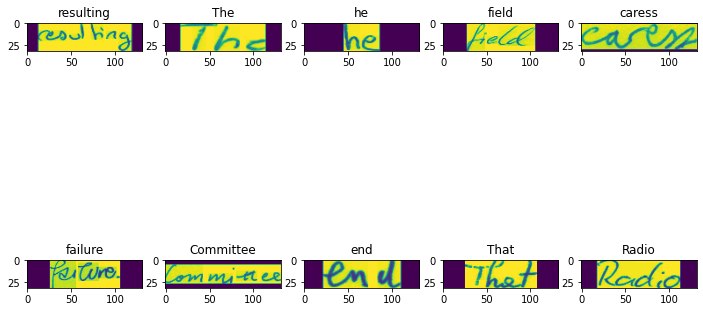

In [15]:
#Display of a random part of the dataset
j=1
plt.figure(figsize=(12,8))
for rand in np.random.choice(np.arange(0, len(X_train_reshaped)), size=10):
    plt.subplot(2,5,j)
    word = y_train.iloc[rand]
    plt.imshow(X_train_reshaped[rand])
    plt.title(word);

    j=j+1

## Vectorization of the labels

In [16]:
from sklearn import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

max_length = max(y_train.apply(len).max(),y_test.apply(len).max())
le = preprocessing.LabelEncoder()
le.fit(list(set(y_train.sum()+y_test.sum())))

print("Classes of LabelEncoder: ",le.classes_)

def word_vectorization(word,max_length,label_encoder):
  le=label_encoder
  vector = le.transform(list(word))
  if len(vector) < max_length:
    addition=(np.ones((max_length-len(vector)))*99).astype("int")
    vector=np.concatenate([vector,addition])

  return vector

Classes of LabelEncoder:  ['!' '"' '#' '&' "'" '(' ')' '+' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z']


In [17]:
def f(word):
  return word_vectorization(word,max_length,le)

y_train_encode = np.stack(y_train.apply(f)) #use of np.stack to have one array and not an array of array
y_test_encode = np.stack(y_test.apply(f))

In [18]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices({"image":X_train_reshaped.reshape([-1,h,w,1]),"label":y_train_encode}).batch(64)
dataset_test = tf.data.Dataset.from_tensor_slices({"image":X_test_reshaped.reshape([-1,h,w,1]),"label":y_test_encode}).batch(64)

#Modelisation

## Model_1

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

def build_model_1(input_shape,output_vector_length):
  ###Lenet model
  model = Sequential()
  model.add(Conv2D(filters=32,
                   kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(filters=64,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding = 'same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(filters=128,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding = 'valid'))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Flatten())

  model.add(Dense(64,activation ="relu"))
  model.add(Dense(128,activation ="relu"))
  model.add(Dense(output_vector_length,activation ="relu"))

  model

  return model

In [19]:
model_input_shape=(h,w,1)
model_1=build_model_1(model_input_shape,max_length)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 130, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 65, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 32, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 30, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 15, 128)      

In [ ]:
plt.plot(range(1,epochs+1),val_acc_lenet,label="lenet_validation")
plt.plot(range(1,epochs+1),train_acc_lenet,label="lenet_train")
plt.legend();

## Model_2

In [ ]:
#@title
from tensorflow import keras
import tensorflow as tf

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(h, w, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((w // 4), (h // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(le.classes_) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img,labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 132, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 132, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 16, 66, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 16, 66, 64)   18496       ['pool1[0][0

In [ ]:
#@title
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

TypeError: ignored

In [ ]:
#@title
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)


# Train the model.
history = model.fit(dataset_train,    
                    epochs=epochs)

Epoch 1/10
171/603 [=======>......................] - ETA: 19s - loss: 18.6990

KeyboardInterrupt: ignored

In [ ]:
#@title

train_ds =  tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train_encode))
validation_ds = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test_encode))

In [ ]:
#@title
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 132), dtype=tf.float64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None))>

In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


#Compilation

###Model_1

In [ ]:
model_1.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


###Model_2

#Training

In [ ]:
epochs=5
training_history_model_1=model_1.fit(X_train_reshaped,y_train_encode,epochs=epochs,batch_size=150, validation_data = (X_test_reshaped,y_test_encode))

In [ ]:
train_acc_model_1 = training_history_lenet.history['accuracy']
val_acc_model_1 = training_history_lenet.history['val_accuracy']

# Prediction

## Decode the vector

In [ ]:
def decode(vector,label_encoder):
  le=label_encoder
  vector_clean=vector[vector!=99]
  vector_decoded=le.inverse_transform(vector_clean)

  return vector_decoded

In [ ]:
  def f(vector):
  return decode(vector,le)
y_train_encode.apply(f)